In [1]:
import numpy as np
import torch
from torch.func import vmap, jacfwd, jacrev
import matplotlib.pyplot as plt
import time

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(torch.cuda.is_available())
print(device)

def grab(x):
    if torch.is_tensor(x):
        x = x.detach().cpu().numpy()
    return x

def ess(At):
    return torch.mean(torch.exp(At))**2 / torch.mean(torch.exp(2*At))

True
cuda


In [3]:
def visualize_lattices(phi, n_rows = 2, n_cols = 5, save = None):
    """
    Visualize a subset of the lattices in a grid.

    Parameters:
    - phi: A tensor of shape [bs, L, L] representing the batch of lattices.
    - n_rows: Number of rows in the subplot grid.
    - n_cols: Number of columns in the subplot grid.
    - title: The title of the plot.
    """
    bs, L, _ = phi.shape
    n_plots = min(n_rows * n_cols, bs)
    print("N ROW:", n_rows)
    print("N COL:", n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(8, 5))

    indices = np.random.choice(bs, n_plots, replace=False)  # Randomly select lattice indices
    
    # indices = np.arange(15,25)
    
    for i, idx in enumerate(indices):
        row = i // n_cols
        col = i % n_cols
        ax = axes[row, col]
        cmap = sns.cubehelix_palette(start=-0.8, rot=0.4, gamma=1.0, dark=0.2, light=0.9, reverse=False, as_cmap=True)
        v = 0.5
        im = ax.imshow(phi[idx], cmap=cmap, origin='lower', vmin=-v, vmax=v)
        ax.axis('off') 

    fig.subplots_adjust( wspace=0.1, hspace=-0.5)
    
    if save is not None:
        plt.savefig(save, bbox_inches='tight')
    # plt.tight_layout()
    plt.show()

## Hamiltonian

In [4]:
def _single_energy(cfg, J, mu, B):
    """
    Compute the energy of a single 2D Ising configuration.
    
    spins: Tensor of shape (L, L) with values in {-1, +1}
    J: coupling constant (float)
    mu: magnetic moment  (float)
    B: external field    (float) 

    Returns: energy.
    """
    L = cfg.shape[0]

    # periodic bcs, shift right on columns and down on rows
    s_right = torch.roll(cfg, shifts=-1, dims=1)
    s_down = torch.roll(cfg, shifts=-1, dims=0)

    interaction = -J * (cfg * (s_right + s_down)).sum()

    ext_field = -mu * B * cfg.sum()
    
    H = interaction + ext_field

    return H

def energy(cfgs, J, mu, B):
    return vmap(_single_energy, in_dims = (0, None, None, None), out_dims=(0))(cfgs, J, mu, B)


def absolute_mag(cfgs, L):
    """
    Compute the absolute magnetization |M| = | \sum_i s_i | on a batch of configurations
    """
    return torch.mean(torch.abs(torch.sum(cfgs, dim= (1,2))) / (L*L))

def mags(cfgs, L):
    """
    Compute the magnetization M =  \sum_i s_i for each configuration in a batch
    """
    return torch.sum(cfgs, dim= (1,2)) / (L*L)


<>:31: SyntaxWarning: invalid escape sequence '\s'
<>:37: SyntaxWarning: invalid escape sequence '\s'
<>:31: SyntaxWarning: invalid escape sequence '\s'
<>:37: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_2735825/1457182349.py:31: SyntaxWarning: invalid escape sequence '\s'
  """
/tmp/ipykernel_2735825/1457182349.py:37: SyntaxWarning: invalid escape sequence '\s'
  """


## Glauber dynamics

In [5]:
def _single_step_glauber(cfg, J, mu, B , beta):
    """
    Perform a Galuber update on a single spin configuration (cfg).
    
    cfg : (L, L)
    J   : coupling constant
    beta: inverse temperature (1 / k_B T))
    
    Returns
    new_cfg:  (L, L)
    """
    
    L = cfg.shape[0]
    
    row = np.random.randint(0, L, ())
    col = np.random.randint(0, L, ())
    spins = cfg[row, col]
    
    # neighbors
    up_row = (row - 1) % L
    down_row = (row + 1) % L
    left_col = (col - 1) % L
    right_col = (col + 1) % L
    
    # local neighbor interaction
    neighbor_sum = cfg[up_row, col] + cfg[down_row, col] + cfg[row, left_col] + cfg[row, right_col]
    local_energy = J * neighbor_sum + mu * B
    delta_E = 2.0 * spins * local_energy
    
    acc = torch.exp(-beta * delta_E)
    acc = torch.minimum(acc, torch.tensor(1)) 

    
    flip =  (torch.rand(1, device=cfg.device) < acc)
    # minus or plus 1 depending on if flip is true or flase respectively
    pm1 = torch.where(flip, torch.tensor(-1.0, device=cfg.device), torch.tensor(1.0, device=cfg.device))
    cfg[row, col] = pm1 * cfg[row, col] 

    return cfg

def step_glauber(cfgs, J, mu, B, beta):
    """
    Perform a Galuber update on a batch of  spin configurations (cfgs).
    """
    bs = cfgs.shape[0]
    return vmap(_single_step_glauber, in_dims = (0, None, None, None, None),
                out_dims=(0), randomness='different')(cfgs, J, mu, B, beta)

# step_glauber(cfgs, J, mu, B , beta)

In [6]:

def run_glauber(bs, L, J, mu, B, beta, n_step, device = 'cpu'):
    """
    Run the Glauber dynamics for n_steps.
    
    bs: number of parallel chains (int)
    L : lattice size (int)
    """
    cfgs = torch.randint(0, 2, (bs, L, L), device=device)
    cfgs = 2*cfgs - 1  
    # print(cfgs.shape)
    
    for step in range(n_step):
        cfgs = step_glauber(cfgs, J, mu, B, beta)
        # cfgs = mcmc_step_batch(cfgs, J, mu, B, beta)
        
    return cfgs


### Run Glauber

In [7]:
bs_test = 15000
L_test = 15
J_test = 1.0
mu_test = 0.0
B_test = 0.0
beta_test = 0.4407
n_step_test = 50000

import time
tic = time.perf_counter()
cfgs_test_NEW = run_glauber(bs_test, L_test, J_test, mu_test, B_test, beta_test, n_step_test, device = 'cpu')
toc = time.perf_counter()
print(toc-tic)

29.74695012718439


In [8]:
print("Absolute mag:", absolute_mag(cfgs_test_NEW, L_test))

Absolute mag: tensor(0.7151)


In [107]:
# mags_test_500steps = mags(cfgs_test, L_test)
# mags_test_1000steps = mags(cfgs_test, L_test)
# mags_test_5000steps = mags(cfgs_test, L_test)
# mags_test_100steps = mags(cfgs_test, L_test)
mags_test_25000steps = mags(cfgs_test, L_test)


In [142]:
# mags_nn = np.load("mags_nn_nstep200_J0.4_beta_0.7_CONV-kernels_5_7_15.npy")
# weights = np.load("mags_nn_nstep200_J0.4_beta_0.7_weights_CONV-kernels_5_7_15.npy")

mags_nn = np.load("mags_nn_nstep200_J0.4_beta_0.7_CONV-kernels_5_7_15.npy")
weights = np.load("mags_nn_nstep200_J0.4_beta_0.7_weights_CONV-kernels_5_7_15.npy")

In [141]:
# print(weights.shape)

(2, 5000)


In [174]:
np.save("mags_test_nstep5000_glauber_L15_J0.4_beta_0.7.npy", mags_test_5000steps)

In [172]:
from scipy.stats import gaussian_kde


# mags_test_5000steps
kde_5000 = gaussian_kde(mags_test_5000steps)
kde_nn = gaussian_kde(mags_nn)
x_vals = np.linspace(min(mags_test_5000steps), max(mags_test_5000steps), 1000)
kde_vals_5000 = kde_5000(x_vals)
kde_vals_nn = kde_nn(x_vals)

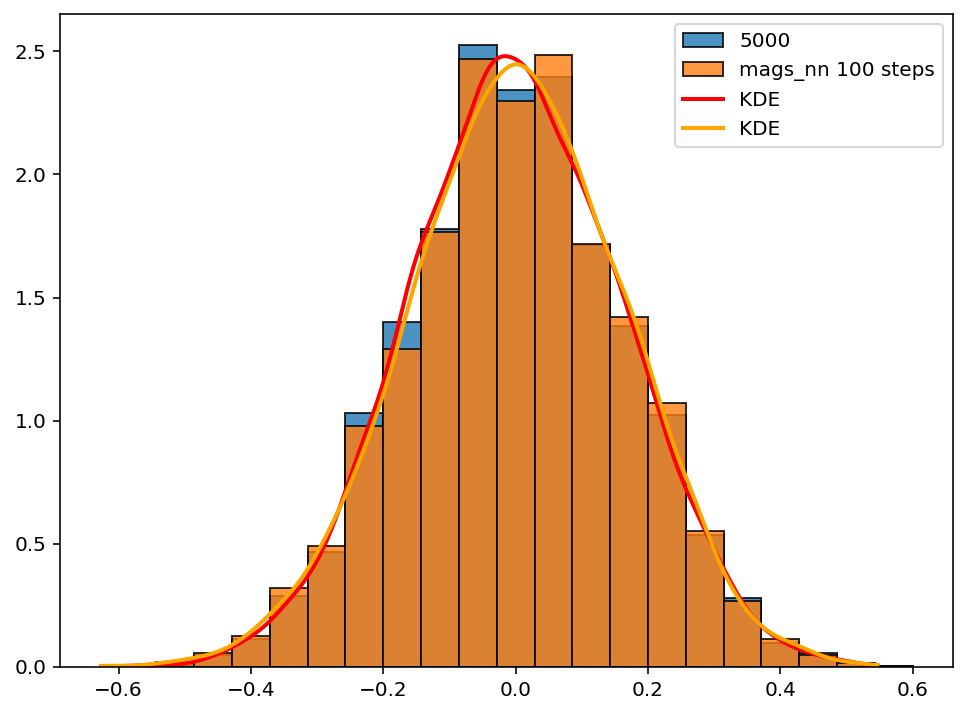

In [173]:
bins = 21
min_mag = -0.6
max_mag = 0.6
bin_edges = np.linspace(min_mag, max_mag, bins + 1)
fig = plt.figure(figsize=(8,6))
# plt.hist(mags_test_25000steps, bins = bin_edges, alpha = 0.9, edgecolor='black', label='25000', density=True);
# plt.hist(mags_test_1000steps, bins = bin_edges, alpha = 0.8, edgecolor='black', label='1000', density=True);
plt.hist(mags_test_5000steps, bins = bin_edges, alpha = 0.8, edgecolor='black', label='5000', density=True);
plt.hist(mags_nn, bins = bin_edges, alpha = 0.8, edgecolor='black', label='mags_nn 100 steps', density=True, weights = None);
# plt.hist(mags_test_500steps, bins = bin_edges, alpha = 0.9, edgecolor='black', density=True);
# plt.hist(mags_test_100steps, bins = bin_edges, alpha = 0.9, edgecolor='black', label='100', density=True);

plt.plot(x_vals, kde_vals_5000, color='red', linewidth=2, label="KDE")
plt.plot(x_vals, kde_vals_nn, color='orange', linewidth=2, label="KDE")

plt.legend()

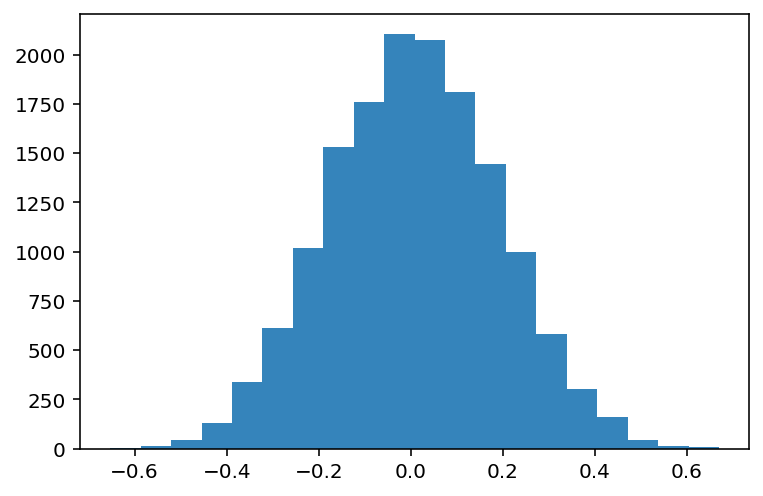

In [121]:
plt.hist(mags_nn, bins = 20, alpha = 0.9, label='mags_nn');


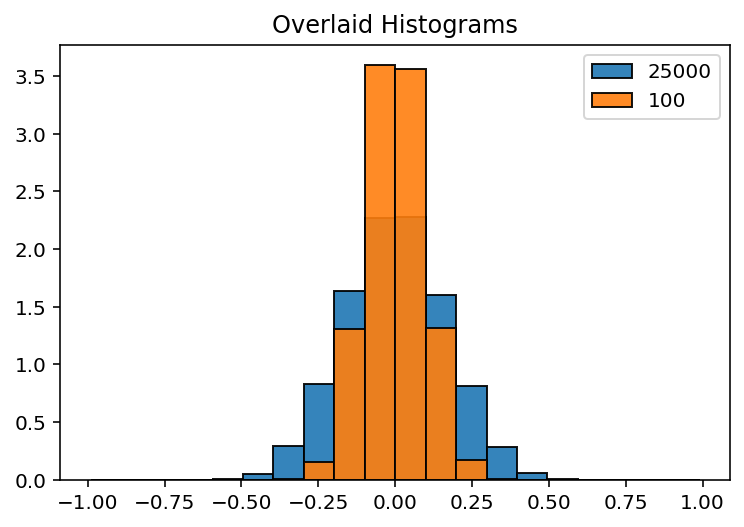

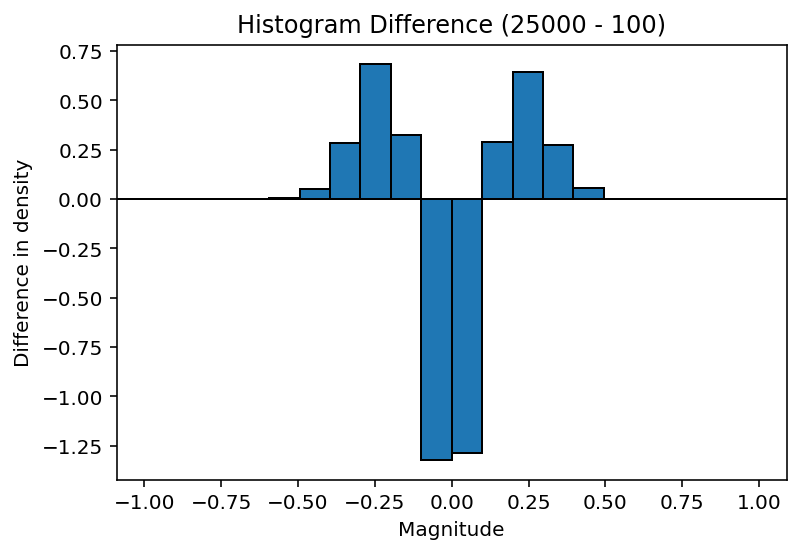

In [126]:
import numpy as np
import matplotlib.pyplot as plt

bins = 20
min_mag = -0.99
max_mag = 0.99
bin_edges = np.linspace(min_mag, max_mag, bins + 1)

# Compute the histogram counts (and not immediately plot them)
vals_25000, _ = np.histogram(mags_test_25000steps, bins=bin_edges, density=True)
vals_100, _   = np.histogram(mags_test_100steps,   bins=bin_edges, density=True)

# Here we compute the difference:
diff = vals_25000 - vals_100

# You could alternatively compute a ratio:
# ratio = vals_25000 / vals_100

# To plot the *original* histograms overlaid
plt.hist(mags_test_25000steps, bins=bin_edges, alpha=0.9, edgecolor='black', label='25000', density=True)
plt.hist(mags_test_100steps,   bins=bin_edges, alpha=0.9, edgecolor='black', label='100',   density=True)
plt.legend()
plt.title("Overlaid Histograms")
plt.show()

# To plot the *difference* as a bar plot
# Let's define the bin centers:
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

plt.bar(bin_centers, diff, width=bin_edges[1]-bin_edges[0], edgecolor='black')
plt.axhline(0, color='black', linewidth=1)
plt.title("Histogram Difference (25000 - 100)")
plt.xlabel("Magnitude")
plt.ylabel("Difference in density")
plt.show()

### Correlation functions

In [10]:
import torch.fft
def compute_correlation_fft_2d(configs, subtract_mean=True):
    """
    Compute the *ensemble-averaged* 2D spin-spin correlation function 
    using FFT-based convolution, for a batch of Ising configs 
    with periodic boundary conditions.
    
    Parameters
    ----------
    configs : torch.Tensor of shape [N, L, L]
        Each entry is either +1 or -1 (or possibly float).
    subtract_mean : bool
        If True, subtract the average spin for each config 
        before computing correlation (i.e. compute connected correlator).
    
    Returns
    -------
    corr2d_avg_shifted : torch.Tensor of shape [L, L]
        The average 2D correlation function. The origin is shifted to (L//2, L//2).
        So corr2d_avg_shifted[L//2, L//2] is g(r=0).
    """
    # Number of configs and lattice size
    N, L, _ = configs.shape

    # Accumulate correlation in Fourier space or real space?
    # We'll compute real-space correlation per config, then average.
    corr_accum = torch.zeros((L, L), dtype=torch.float64)

    for i in range(N):
        s = configs[i].to(dtype=torch.float64)  # shape [L, L]
        
        # Optionally subtract mean spin (for connected correlation)
        if subtract_mean:
            s_mean = s.mean()
            s = s - s_mean
        
        # Forward 2D FFT
        s_fft = torch.fft.fftn(s, dim=(-2, -1))
        
        # Power spectrum: multiply by complex conjugate
        pspec = s_fft * s_fft.conj()
        
        # Inverse FFT to get correlation
        corr2d = torch.fft.ifftn(pspec, dim=(-2, -1)).real
        
        # Normalize by number of sites
        corr2d = corr2d / (L * L)
        
        # Accumulate
        corr_accum += corr2d
    
    # Average over the N configurations
    corr2d_avg = corr_accum / N
    
    # Shift so that the "zero-distance" is in the center
    corr2d_avg_shifted = torch.fft.fftshift(corr2d_avg, dim=(-2, -1))
    
    return corr2d_avg_shifted


def plot_2d_correlation(corr2d, title="2D Correlation"):
    """
    Plot the 2D correlation array using imshow (with origin in the middle).
    """
    plt.figure(figsize=(6,5))
    # corr2d is already shifted so that the origin is in the center
    plt.imshow(corr2d.numpy(), cmap='viridis', origin='upper')
    plt.colorbar(label="g(r)")
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_1d_slice(corr2d, title="1D Slice through center"):
    """
    Take a 1D slice through the center row of the correlation array (already fft-shifted),
    and plot g(r) from 0..L-1 along that row.
    """
    L = corr2d.shape[0]
    mid = L // 2
    
    # middle row
    row_data = corr2d[mid, :].numpy()
    
    # We'll just plot from left to right, but keep in mind that index 0
    # in the shifted array is effectively r = -L/2 in real space.
    plt.figure()
    plt.plot(np.arange(L), row_data, 'o-', label='g(mid, x)')
    plt.xlabel("Shifted x index")
    plt.ylabel("Correlation")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

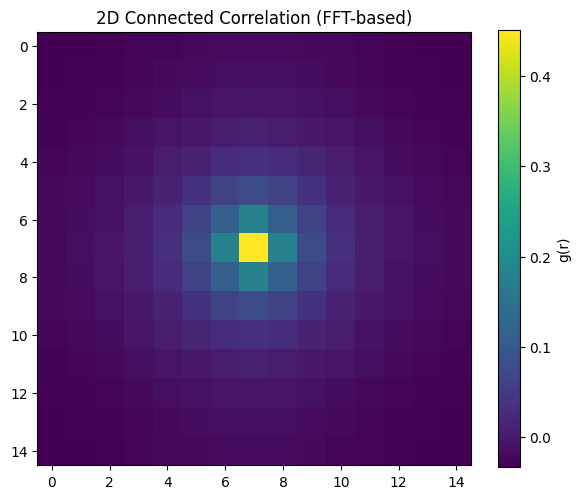

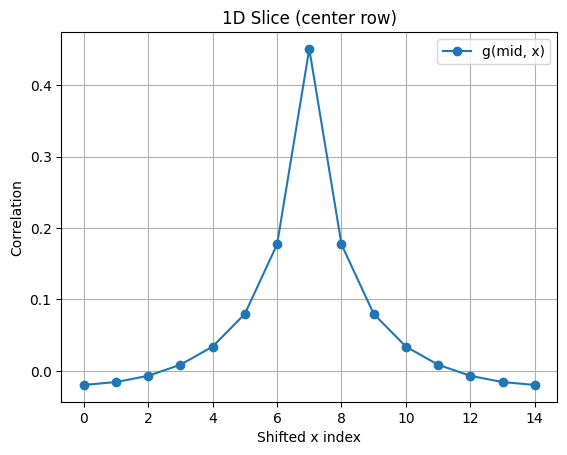

In [11]:
# cfgs = torch.randint(0, 2, (1000, 15, 15), device=device)
corr2d_avg = compute_correlation_fft_2d(cfgs_test_NEW, subtract_mean=True)

# Plot as 2D image
plot_2d_correlation(corr2d_avg, title="2D Connected Correlation (FFT-based)")

# Plot a 1D slice across the middle row
plot_1d_slice(corr2d_avg, title="1D Slice (center row)")

In [179]:
import torch
import torch.fft

def compute_correlation_fft_2d_per_config(configs, subtract_mean=True):
    """
    Compute the 2D spin-spin correlation function for each config separately
    using FFT-based convolution (periodic boundary conditions).
    
    Parameters
    ----------
    configs : torch.Tensor of shape [N, L, L]
        Batch of Ising configurations (+/- 1 or float).
    subtract_mean : bool
        If True, subtract the average spin (connected correlation).
    
    Returns
    -------
    corr2d_list : torch.Tensor of shape [N, L, L]
        corr2d_list[i] is the correlation map (already fftshifted)
        for the i-th configuration.
    """
    N, L, _ = configs.shape
    
    # We'll store one correlation map per config
    corr2d_list = torch.zeros((N, L, L), dtype=torch.float64)
    
    for i in range(N):
        s = configs[i].to(dtype=torch.float64)  # shape (L, L)
        
        if subtract_mean:
            s_mean = s.mean()
            s = s - s_mean
        
        # FFT
        s_fft = torch.fft.fftn(s, dim=(-2, -1))
        
        # Multiply by its complex conjugate => power spectrum
        pspec = s_fft * torch.conj(s_fft)
        
        # Inverse FFT => correlation
        corr2d = torch.fft.ifftn(pspec, dim=(-2, -1)).real
        
        # Divide by total number of sites
        corr2d /= (L*L)
        
        # Shift the zero-frequency component to the center
        corr2d = torch.fft.fftshift(corr2d, dim=(-2, -1))
        
        corr2d_list[i] = corr2d
    
    return corr2d_list

def extract_1d_center_slice(corr2d):
    """
    Extract the middle row from a 2D correlation map
    (already fft-shifted).
    """
    L = corr2d.shape[0]
    mid = L // 2
    return corr2d[mid, :]  # shape [L]


def gather_1d_slices(corr2d_list):
    """
    Given corr2d_list of shape [N, L, L],
    extract the 1D middle-row slice for each configuration
    and return a tensor of shape [N, L].
    """
    N, L, _ = corr2d_list.shape
    slices_1d = torch.zeros((N, L), dtype=torch.float64)
    for i in range(N):
        slices_1d[i] = extract_1d_center_slice(corr2d_list[i])
    return slices_1d  # shape [N, L]


def compute_mean_jackknife(slices_1d):
    """
    Compute the mean correlation function and jackknife error bars.
    
    slices_1d: torch.Tensor of shape [N, L].
    """
    N, L = slices_1d.shape
    # Full mean
    mean_slice = slices_1d.mean(dim=0)
    
    # We want to remove the i-th config in turn:
    # "leave-one-out" means:
    #  JK_i(x) = (1/(N-1)) * sum_{j != i} slices_1d[j, x]
    
    # We'll store the results in a NxL array
    jk_estimates = torch.zeros((N, L), dtype=torch.float64)
    
    sum_all = slices_1d.sum(dim=0)  # shape [L]
    for i in range(N):
        jk_estimates[i] = (sum_all - slices_1d[i]) / (N - 1)
    
    # Now the jackknife mean at each x is the average of JK_i(x).
    jk_mean = jk_estimates.mean(dim=0)  # shape [L]
    # In principle, jk_mean should be very close to mean_slice.
    
    # Variance from the jackknife formula:
    # var_jk(x) = (N-1) * < (JK_i(x) - JK_mean(x))^2 > over i
    diffs = jk_estimates - jk_mean  # shape [N, L]
    var_jk = (N - 1) * (diffs**2).mean(dim=0)  # shape [L]
    
    err_jk = var_jk.sqrt()  # shape [L]
    
    return mean_slice, err_jk


def compute_mean_std_error(slices_1d):
    """
    slices_1d: torch.Tensor of shape [N, L]
        slices_1d[i, :] is the 1D correlation for config i.
    
    Returns:
    --------
    mean_slice: torch.Tensor [L]
    err_slice: torch.Tensor [L]
        Standard error of the mean (1-sigma).
    """
    N, L = slices_1d.shape
    # Mean along the config dimension
    mean_slice = slices_1d.mean(dim=0)  # shape [L]
    # Std dev along the config dimension
    std_slice = slices_1d.std(dim=0, unbiased=True)  # shape [L]
    # Standard error
    err_slice = std_slice / (N**0.5)
    
    return mean_slice, err_slice

tensor([0.0003, 0.0002, 0.0002, 0.0002, 0.0003, 0.0004, 0.0007, 0.0011, 0.0007,
        0.0004, 0.0003, 0.0002, 0.0002, 0.0002, 0.0003], dtype=torch.float64)


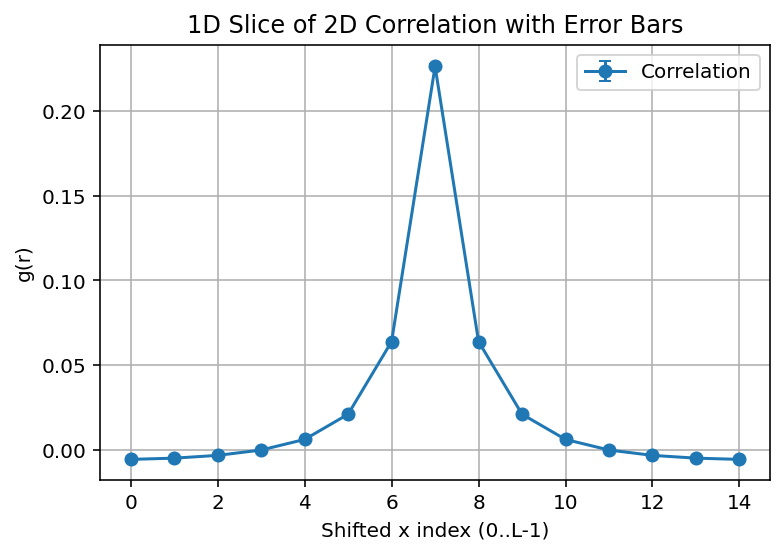

In [188]:
L = 15
corr2d_list = compute_correlation_fft_2d_per_config(cfgs_test_NEW, subtract_mean=True)
# shape [N, L, L]

# 3) Extract the middle-row slice for each config
slices_1d = gather_1d_slices(corr2d_list)  # shape [N, L]

# 4) Compute mean and error bars (choose standard or jackknife)
mean_slice, err_slice = compute_mean_std_error(slices_1d)
# mean_slice, err_slice = compute_mean_jackknife(slices_1d)
print(err_slice)

# 5) Plot with errorbars
x_vals = np.arange(L)  # indices 0..L-1 in the shifted array
plt.errorbar(x_vals, mean_slice.numpy(), yerr=err_slice.numpy(), 
             fmt='o-', capsize=3, label="Correlation")
plt.xlabel("Shifted x index (0..L-1)")
plt.ylabel("g(r)")
plt.title("1D Slice of 2D Correlation with Error Bars")
plt.grid(True)
plt.legend()
plt.show()

In [182]:
np.save("tpcf_truth_mean.npy", mean_slice.numpy())
np.save("tpcf_truth_err.npy", err_slice.numpy())